In [1]:
from pathlib import Path
import sys
import cv2
import os
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam

2024-05-23 13:25:10.848794: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 13:25:10.925617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 13:25:12.271330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Training the U-Net

## Importing auxiliary functions

Here, we are adding the `root` directory in order to load a few auxiliary functions.

In [2]:
sys.path.append("..")  # fix

Now, we are importing some auxiliary functions:
 - `conv2d_block` is used to create a convolution block from parameters
 - `read_dataset` reads the labelled dataset (see `dataset_creation_example` notebook for reference)

In [3]:
from training.simple.conv2d_block import conv2d_block
from training.simple.read_dataset import read_dataset

## Defining the path of the dataset

After importing the auxiliary functions, it is necessary to define the path for the `dataset_folder`, as shown below.

In [4]:
dataset_folder = Path(r"../dataset/dataset_UNET")

## Reading the dataset

Now, it's time to load the dataset. Here we are dividing the labelled samples (images and masks) into a "Training" and "Validation" dataset.
Here, it's also necessary to define the `window_size`. This parameter is used to reshape the sub-images size (see `dataset_creation_example` notebook for reference). It is important to highlight that this parameter is used only to rescale images. **It does not change the sub-image area, it simply scales up or down the sub-images. If you do not want to rescale the image, simply let `window_size = sub_image_size`.**

Taking the `dataset_creation_example` notebook as an example:

In [5]:
window_size = 128

In [6]:
images_train, masks_train = read_dataset(
    dataset_folder, window_size=window_size, subset="Training"
)

images_val, masks_val = read_dataset(
    dataset_folder, window_size=window_size, subset="Validation"
)

After reading the dataset, we shuffle the dataset. Note that we are using a `seed` value of 13 to generate the "random" shuffling.

In [7]:
N_dataset = images_train.shape[0]
shuffle = np.arange(N_dataset)
np.random.seed(13)
np.random.shuffle(shuffle)
images_train = images_train[shuffle, :, :, :]
masks_train = masks_train[shuffle, :, :, :]

## Defining the U-Net architecture

Now that the training and validation data is available, we can now focus on defining the U-Net architecture.
An example is shown below. For reference, this U-Net network is similar to the one shown in Fig. 4 of [this work](https://www.sciencedirect.com/science/article/pii/S0301932222002634#sec3).

In [8]:
input_img = Input((window_size, window_size, 1), name="img")

c1 = conv2d_block(input_img, 8, kernel_size=5, batchnorm=True)
p1 = MaxPooling2D((4, 4))(c1)

c2 = conv2d_block(p1, 8, kernel_size=5, batchnorm=True)
p2 = MaxPooling2D((4, 4))(c2)

c3 = conv2d_block(p2, 8, kernel_size=5, batchnorm=True)

u4 = Conv2DTranspose(8, kernel_size=5, strides=(4, 4), padding="same")(c3)
u4 = concatenate([u4, c2])
c4 = conv2d_block(u4, 8, kernel_size=5, batchnorm=True)

u5 = Conv2DTranspose(8, kernel_size=5, strides=(4, 4), padding="same")(c4)
u5 = concatenate([u5, c1])
c5 = conv2d_block(u5, 8, kernel_size=5, batchnorm=True)

outputs = Conv2D(1, (1, 1), activation="sigmoid")(c5)
model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer=Adam(), loss="binary_crossentropy")

2024-05-23 13:25:14.253934: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Below we can get a summary of the model. Alternatively (and recommended), you can check the U-Net architecture with Keras' `plot_model` function (see [here](https://keras.io/api/utils/model_plotting_utils/)).

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        208 │ img[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32, 8) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 8) │      1,608 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 8)   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 8)   │      1,608 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8)   │         32 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 8, 8, 8)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32, 8) │      1,608 │ activation_5[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 16)               │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32, 8) │      3,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      1,608 │ activation_7[0][

 Total params: 13,225 (51.66 KB)

 Trainable params: 13,145 (51.35 KB)

 Non-trainable params: 80 (320.00 B)

## Training the model

Now, with the U-Net model defined, it's time to train it!

First, we setup a few callbacks to be executed during training.

The first one is the `early_stopping` callback, which defines a `PATIENCE` value to limit the number of running epochs (`EPOCHS`).

The second one, `best_model`, is a callback to store the U-Net with the lowest validation loss.

The final, and third callback, is `TrackProgress()`, which tracks the training progress of the U-Net. 
It consists of image samples from the `Validation` dataset, showing: i) raw image; ii) manually labelled mask, and iii) U-Net generated mask. 
It's a useful tool to check the training progress.

In [10]:
PATIENCE = 200
EPOCHS = 2000

In [11]:
class TrackProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        out_progress_folder = Path("progress/best")
        if epoch == 0:
            out_progress_folder.mkdir(parents=True, exist_ok=True)
        if epoch % 10 == 0:
            _images = images_val[::16, :, :].copy()
            _masks = masks_val[::16, :, :].copy()

            n_tests = _images.shape[0]
            _pred_masks = model.predict(_images)

            _images *= 255.0
            _masks *= 255.0
            _pred_masks *= 255.0

            for i in range(n_tests):
                _img = _images[i, :, :, 0].astype(np.uint8)
                _mask = _masks[i, :, :, 0].astype(np.uint8)
                _pred_mask = _pred_masks[i, :, :, 0].astype(np.uint8)
                _out_img = np.hstack((_img, _mask, _pred_mask))
                cv2.imwrite(
                    str(
                        Path(
                            out_progress_folder,
                            f"progress_img_ex_{i:03d}_{epoch:05d}.jpg",
                        )
                    ),
                    _out_img,
                )

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=PATIENCE
)

best_model = ModelCheckpoint(
    "UNET_best.keras", verbose=1, save_best_only=True, monitor="val_loss", mode="auto"
)

Now that everything is defined, it's time to train the U-Net with our data. 
This is done below. It'll probably take a while to run...

While training, you'll notice that a `progress/best` folder is created to monitor the training progress.
Furthermore, the network with the lowest validation loss at a number of given epochs will be stored in a `UNET_best.keras` file.

In [13]:
BATCH_SIZE = 128

model.fit(
    images_train,
    masks_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(images_val, masks_val),
    callbacks=[early_stopping, best_model, TrackProgress()],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.52062, saving model to UNET_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step

Epoch 2: val_loss improved from 0.52062 to 0.46848, saving model to UNET_best.keras

Epoch 3: val_loss improved from 0.46848 to 0.42592, saving model to UNET_best.keras

Epoch 4: val_loss improved from 0.42592 to 0.38403, saving model to UNET_best.keras

Epoch 5: val_loss improved from 0.38403 to 0.35628, saving model to UNET_best.keras

Epoch 6: val_loss improved from 0.35628 to 0.35041, saving model to UNET_best.keras

Epoch 7: val_loss did not improve from 0.35041

Epoch 8: val_loss did not improve from 0.35041

Epoch 9: val_loss did not improve from 0.35041

Epoch 10: val_loss did not improve from 0.35041

Epoch 11: val_loss did not improve from 0.35041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Epoch 12: val_loss did not improve from 0.35041

Epoch 13: val_loss did not improve from 0.35041

Epoch 14: val_loss improved from 0.35041 to 0.33811, saving model to UNET_be

At this point, the model is trained. In order to use the model as a segmentation tool, please check the `predicting_example`.

As a reference, look at the U-Net generated segmentation masks obtained in selected epochs during training.

### Epoch 0000:
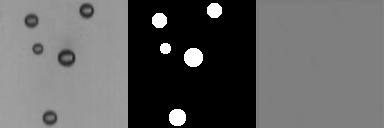

### Epoch 0060:
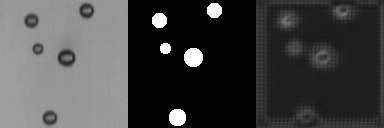

### Epoch 0100:
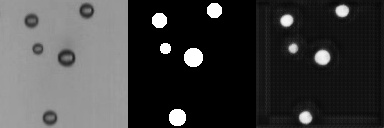

### Epoch 0580:
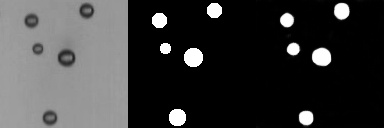
